KHAI BÁO THƯ VIỆN

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
from sklearn.svm import SVC
import torch
from sklearn.decomposition import PCA


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: cuda


LOAD DATASET

In [3]:
x_train_scaled_loaded = joblib.load('../data/multi_class/x_train_scaled_multi_class.pkl')
x_test_scaled_loaded  = joblib.load('../data/multi_class/x_test_scaled_multi_class.pkl')
y_train_loaded        = joblib.load('../data/multi_class/y_train_multi_class.pkl')
y_test_loaded         = joblib.load('../data/multi_class/y_test_multi_class.pkl')
le = joblib.load("../data/multi_class/label_encoder.pkl")

In [4]:
x_train_scaled_loaded = x_train_scaled_loaded.to_numpy()
x_test_scaled_loaded  = x_test_scaled_loaded.to_numpy() 
y_train_loaded = y_train_loaded.to_numpy()
y_test_loaded  = y_test_loaded.to_numpy()

In [5]:
print (x_train_scaled_loaded.shape)
print (y_train_loaded.shape)

print (x_test_scaled_loaded.shape)
print (y_test_loaded.shape)

(8012, 27)
(8012,)
(2003, 27)
(2003,)


SVM without hyperparameter

In [6]:
svm_model1 = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42) 
svm_model1.fit(x_train_scaled_loaded, y_train_loaded)
svm_model1.score(x_test_scaled_loaded , y_test_loaded)

0.7329006490264603

In [7]:
y_pred = svm_model1.predict(x_test_scaled_loaded)
precision = precision_score(y_test_loaded, y_pred, average='weighted') # average='weighted' là tính toán trung bình có trọng số bằng với số lượng mẫu của mỗi lớp
recall = recall_score(y_test_loaded, y_pred, average='weighted')
f1 = f1_score(y_test_loaded, y_pred, average='weighted')

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

Precision : 0.6928
Recall    : 0.7329
F1-score  : 0.6979


DÙNG OPTUNA ĐỂ TÌM RA BỘ SIÊU THAM SỐ

In [8]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số điều chỉnh độ phạt
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf','poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto',0.01, 0.001])
    degree = trial.suggest_int('degree', 2, 3)  # Bậc của đa thức nếu kernel='poly'

    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        class_weight= None , 
        random_state=42,
        decision_function_shape="ovr" # SVM đa lớp sử dụng one-vs-rest
    )

    cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
    )

    score = cross_val_score(
        model,
        x_train_scaled_loaded,
        y_train_loaded,
        cv=cv,
        scoring="f1_weighted"  # Sử dụng F1_weighted cho đánh giá đa lớp
    ).mean()

    return score


In [9]:
# Tạo một study Optuna để tối ưu hóa siêu tham số cho mô hình SVC
# Sử dụng thuật toán TPE với seed=42 để đảm bảo tính tái lập
# direction='maximize' nghĩa là muốn tối đa hóa giá trị trả về từ objective 

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

# Thực hiện tối ưu hóa với 10 lần thử nghiệm (n_trials=10)
# objective là hàm mục tiêu đã định nghĩa ở trên, trả về độ chính xác trung bình qua cross-validation

study.optimize(objective, n_trials=10)


[I 2026-01-27 22:58:27,507] A new study created in memory with name: no-name-674a029b-a678-4bd6-87d5-6ca6dd8c015b
C:\Users\PC\AppData\Local\Temp\ipykernel_22008\3738530246.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số điều chỉnh độ phạt
[I 2026-01-27 22:58:29,038] Trial 0 finished with value: 0.662217639917107 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 0.001, 'degree': 3}. Best is trial 0 with value: 0.662217639917107.
C:\Users\PC\AppData\Local\Temp\ipykernel_22008\3738530246.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số

In [10]:
best_params_from_optuna = study.best_params
best_params_from_optuna

{'C': 5.492736444508448, 'kernel': 'linear', 'gamma': 0.001, 'degree': 2}

In [11]:
# Sử dụng GridSearchCV để tinh chỉnh thêm các siêu tham số dựa trên kết quả từ Optuna
# Định nghĩa lưới siêu tham số để tìm kiếm
# Chỉ sử dụng giá trị tốt nhất của C từ Optuna, các tham số khác sẽ được thử nghiệm với nhiều giá trị hơn
param_grid = {
    'C': [best_params_from_optuna['C']] ,
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'degree': [2, 3],
}

svm_model = SVC()

cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

# Thiết lập GridSearchCV với mô hình SVC và lưới siêu tham số
clf = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=cv,
    verbose=0,
    n_jobs=-1,
    scoring='f1_weighted'  # Sử dụng F1_weighted cho đánh giá đa lớp
)

best_svm = clf.fit(x_train_scaled_loaded, y_train_loaded)

ĐÁNH GIÁ MÔ HÌNH

In [12]:
y_pred = best_svm.predict(x_test_scaled_loaded)
print(y_pred)

[5 4 4 ... 4 4 4]


In [13]:
print(le.classes_)

['Actinic keratoses' 'Basal cell carcinoma' 'Benign keratosis'
 'Dermatofibroma' 'Melanocytic nevus' 'Melanoma' 'Vascular lesions']


Accuracy : 0.7299051422865701
Precision : 0.6954965844941073
Recall : 0.7299051422865701
F1-score : 0.7050830448827751

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.33      0.06      0.10        65
Basal cell carcinoma       0.32      0.20      0.25       103
    Benign keratosis       0.43      0.49      0.46       220
      Dermatofibroma       0.67      0.26      0.38        23
   Melanocytic nevus       0.85      0.94      0.89      1341
            Melanoma       0.38      0.29      0.33       223
    Vascular lesions       0.38      0.18      0.24        28

            accuracy                           0.73      2003
           macro avg       0.48      0.35      0.38      2003
        weighted avg       0.70      0.73      0.71      2003



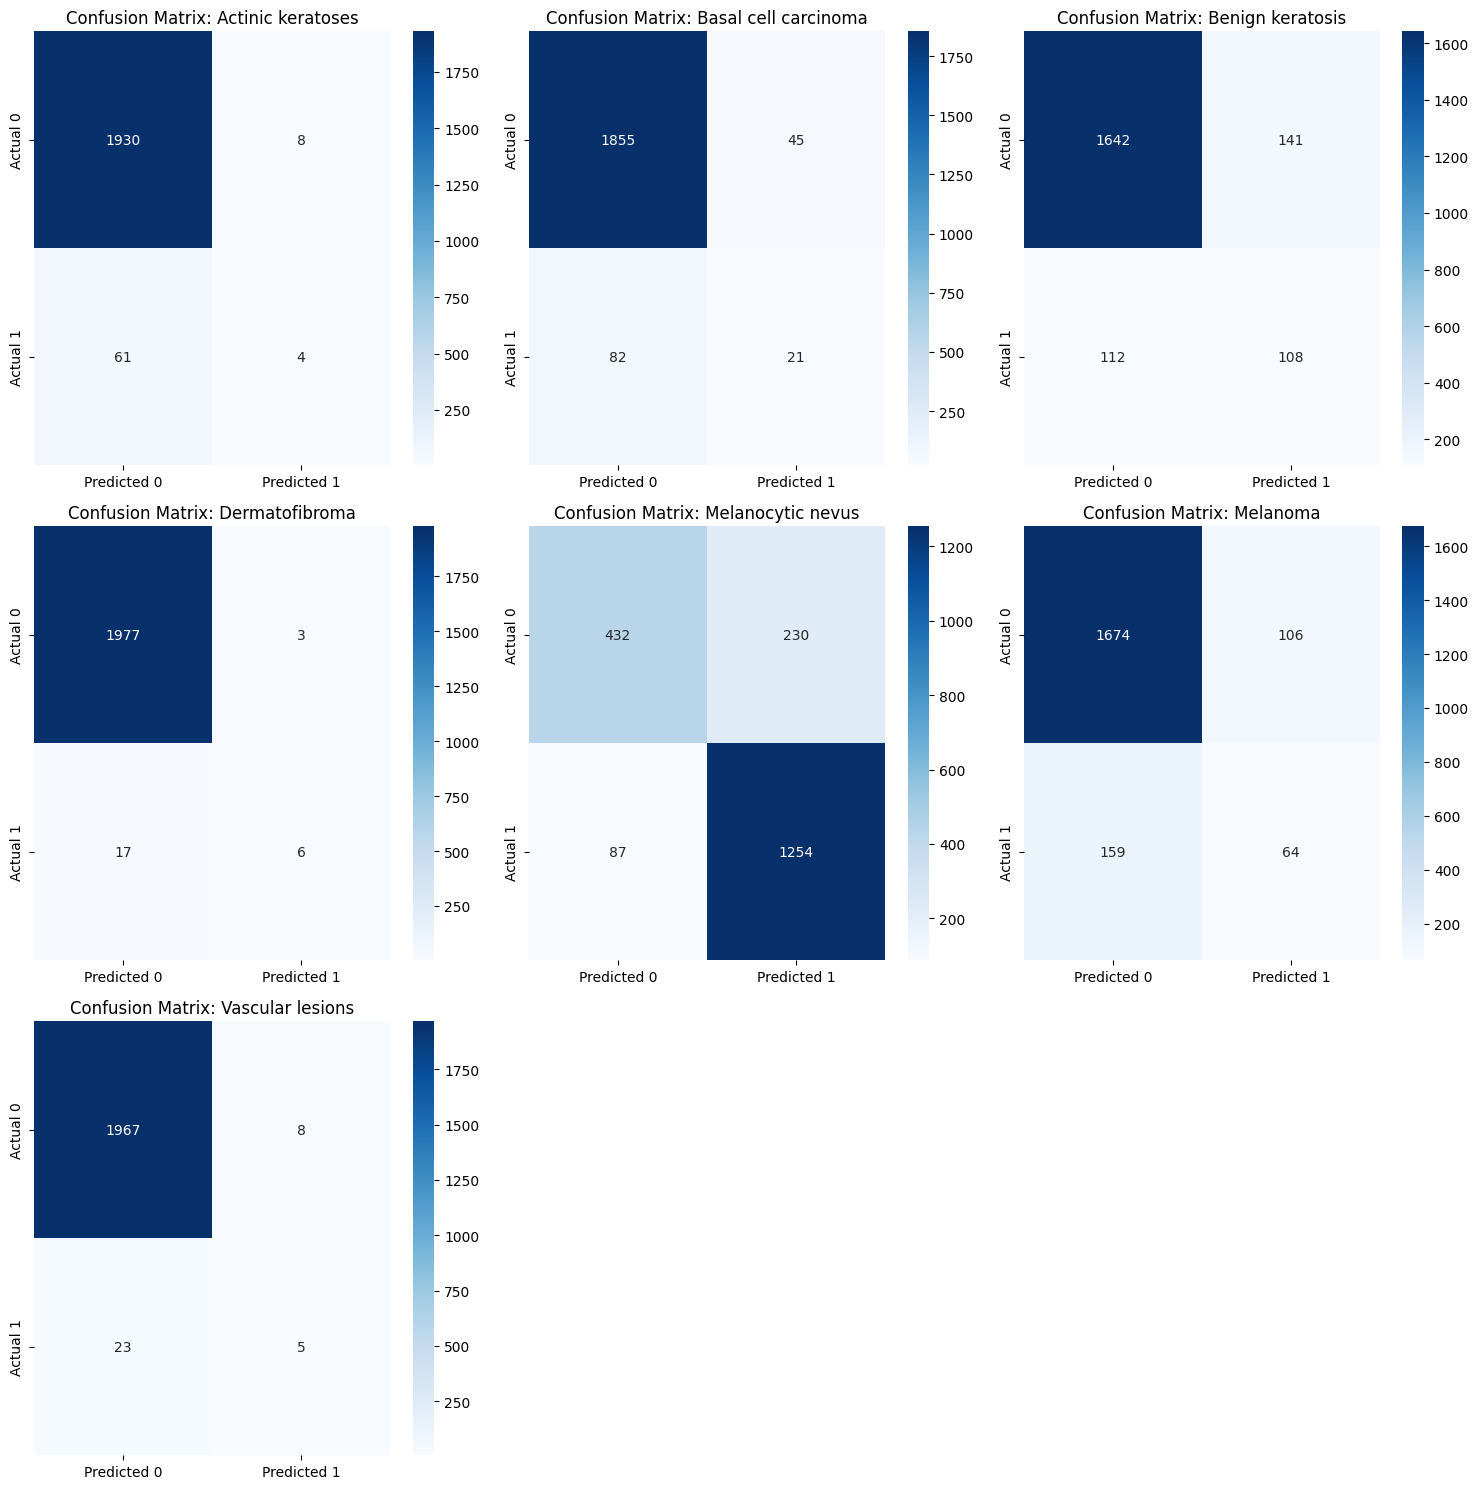

In [14]:
accuracy = accuracy_score(y_test_loaded, y_pred)
precision = precision_score(y_test_loaded, y_pred, average="weighted")
recall = recall_score(y_test_loaded, y_pred, average="weighted")
f1 = f1_score(y_test_loaded, y_pred, average="weighted")

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1-score :", f1)

# 3. Classification Report (từng lớp)
print("\nClassification Report:")
print(classification_report(
    y_test_loaded,
    y_pred,
    target_names=le.classes_
))

# 4. Confusion Matrix (7x7)
class_names = le.classes_
n_classes = len(class_names)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    # One-vs-Rest ground truth & prediction
    y_true_binary = (y_test_loaded == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[i],
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1']
    )

    axes[i].set_title(f"Confusion Matrix: {class_name}")

for j in range(n_classes, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


LƯU MODEL

In [17]:
joblib.dump(best_svm, "../model/svm_multi_class_model.joblib")

['../model/svm_multi_class_model.joblib']